<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/anomaly_detection_gist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from os.path import join
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization
import matplotlib.pyplot as plt
import argparse
import numpy as np
from os.path import dirname

class Config:
    def __init__(self, data_dir):
        self.DATASET_PATH = join(data_dir,"UCSDped1/Train")
        self.SINGLE_TEST_PATH = join(data_dir,"UCSDped1/Test/Test020")
        self.BATCH_SIZE = 4
        self.EPOCHS = 3
        self.MODEL_PATH = join(data_dir,"model.hdf5")




def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_training_set(conf):
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips


def get_model(conf,reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if reload_model:
        return load_model(conf.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set(conf)
    training_set = np.array(training_set)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    !mkdir training_1
    checkpoint_path = "training_1/cp.ckpt"
    checkpoint_dir = dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

    seq.fit(training_set, training_set,
            batch_size=conf.BATCH_SIZE, epochs=conf.EPOCHS, shuffle=False, callbacks=[cp_callback])
    seq.save(conf.MODEL_PATH)
    return seq



def TEST_get_training_set(conf):
    print("Starting")
    clips =  get_training_set(conf)
    print("Total clips: %d" % len(clips))
    for clip in clips:
        print("Sequence size: %d" % len(clip))
        for image in clip:
            plt.imshow(np.uint8(image))
            plt.show()



def get_single_test(conf):
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(conf.SINGLE_TEST_PATH)):
        if str(join(conf.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(conf.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test



def evaluate(conf):
    model = get_model(conf, True)
    print("got model")
    test = get_single_test(conf)
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()




/content










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


got model
got test


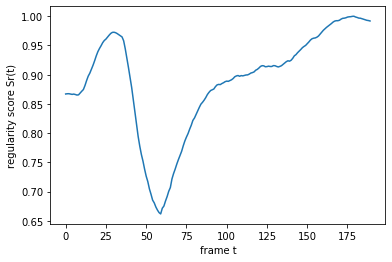

In [11]:


# Instantiate the parser
#parser = argparse.ArgumentParser(description='Vidasa Extended -- Anomaly Detection System')


#parser.add_argument('--data',type=str,
 #                   help='Data directory path')

#args = parser.parse_args()
!pwd
conf = Config(data_dir="/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/")

evaluate(conf)
#TEST_get_training_set(conf)




In [1]:
pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5268 sha256=8374702610fb894b4613df7f876a77593bf454ea5413ab04b9e127040d700fab
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
